# Data Collection of Music Artist Predictor

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Installation-of-lyricsgenius-by-johnwmillr" data-toc-modified-id="Installation-of-lyricsgenius-by-johnwmillr-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Installation of lyricsgenius by johnwmillr</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Genius-DataFrame-Creation" data-toc-modified-id="Genius-DataFrame-Creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Genius DataFrame Creation</a></span></li></ul></div>

### Imports

In [1]:
import pandas as pd
import numpy as np
import json
from time import sleep
from random import randint
import requests
import re
import unidecode
from tqdm import tqdm
import pprint

### Installation of lyricsgenius by johnwmillr

Source: https://github.com/johnwmillr/LyricsGenius

The Genius API wrapper was installed by entering the following into the terminal's bash:

```pip install lyricsgenius```

This created the lyricsgenius folder in the current working directory. To run the scripts the lyricsgenius folder was moved into the same folder as the jupyter notebook and the working directory changed to that folder.

lyricsgenius was imported into the jupyter notebook as genius and the api object created passing the client_access_token received from the Genius developer account (see below). 

https://genius.com/developers

In [2]:
import lyricsgenius as genius
api = genius.Genius(client_access_token='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')

### Functions

In [3]:
def artist_song_dict(artist_list, spotify):
    '''This function takes a list of music artist and a dataframe containing artist_names and track_names
        and will return a dictionary containing artist names as keys and a list of their songs found in 
        the dataframe as the values. The function excludes any songs which contain the expressions:
        - 'Remastered' or 'Remaster'
        - 'feat' or 'ft.' 
        - 'Remix', 'RMX' or 'Mix'
        - 'Spotify'
        - 'Studios'
        - 'Christmas'
        - 'Single Version', 'Album Version' or 'Version'
        - 'BBC'
        - 'Demo'
        - 'Edition'
        - 'Mono'
        - 'Live from', 'Live At' or 'Live at'
        - 'Soundtrack'
    '''
    artist_dict = {}
    for artist in artist_list:
        songs = []
        for item in spotify.track_name[(spotify.artist_name==artist)&(spotify.track_name.str.contains(r'Remastered|Remaster')==False)&(spotify.track_name.str.contains(r'feat.|ft.')==False)&(spotify.track_name.str.contains(r'Remix|remix|RMX|Mix')==False)&(spotify.track_name.str.contains(r'Spotify|Studios|Soundtrack')==False)&(spotify.track_name.str.contains(r'Christmas')==False)&(spotify.track_name.str.contains(r'Single Version|Album Version|Version|BBC|Demo|Edition|Mono')==False)&(spotify.track_name.str.contains(r'Live from|Live at|Live At|live at')==False)]:
            songs.append(item)
        songs = list(set(songs))
        artist_dict[artist] = songs
    return artist_dict

In [4]:
def missing_songs(artists_list, artist_dict, scraped_dataframe):
    '''This function accepts a created artist list, its derived dictionary with songs, 
        and a lyrics genius dataframe. It returns a dictionary containing the artists and the songs that weren't 
        successfully scraped.'''
    missing_songs_dict = {}
    for artist in artists_list:
        tracks = []
        for item in artist_dict[artist]:
            if item not in list(scraped_dataframe[scraped_dataframe.artist_name==artist].track_name):
                tracks.append(item)
        missing_songs_dict[artist] = tracks
    return missing_songs_dict

In [5]:
def genius_lyrics_dataframe(artist_dict):
    '''This function accepts a dictionary holding artist names as keys and their songs as values.
    Through the lyricsgenius wrapper it is able to populate a dataframe.
    The function returns the scraped dataframe containing the variables:
    - track_name
    - artist_name
    - release_year
    - spotify_uri
    - genius_url
    - lyrics
    '''
    song_titles = []
    song_artists = []
    releases = []
    uris = []
    urls = []
    lyrs = []
    for key in artist_dict.keys():
        for song_title in tqdm(artist_dict[key]):
            try:
                song =api.search_song(song_title, key)

                song_json = song.to_json()

                try:
                    song_titles.append(song.title)
                except:
                    song_titles.append(np.nan)

                try:
                    song_artists.append(song.artist)
                except:
                    song_artists.append(np.nan)

                try:
                    releases.append(song.year)
                except:
                    releases.append(np.nan)

                uri = np.nan
                for i in range(0,len(song.media)):
                    if 'native_uri' in song.media[i].keys():
                        uri = song.media[i]['native_uri']
                    else:
                        pass
                uris.append(uri)


                try:
                    urls.append(song_json['songs'][0]['url'])
                except:
                    urls.append(np.nan)

                try:
                    lyrs.append(song.lyrics)
                except:
                    lyrs.append(np.nan)
            except:
                pass
            
    return pd.DataFrame.from_dict({'track_name': song_titles, 
                                   'artist_name': song_artists, 
                                   'release_year': releases, 
                                    'spotify_uri': uris,
                                   'genius_url':urls, 
                                   'lyrics':lyrs})

### Genius DataFrame Creation

* The spotify audio data was retrieved from a Kaggle dataset found in the link below.

https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

* A random set of artists was selected and a list created. 

* From these artists their songs were extracted form the Kaggle dataset (dataframe --> spotify) with the artist_song_dict( ) function.

In [6]:
spotify = pd.read_csv('/Users/constancemaurer/GA DSI 12/DSI12-lessons/projects/project-capstone/personal-github/Resources/SpotifyFeatures_Kaggle_TracksDB.csv')

In [7]:
spotify.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [8]:
spotify.shape

(232725, 18)

**To start with, the Kaggle dataset has a lot of duplicated entries as a lot of songs fall under multiple genres, hence I dropped these multiple copies of a song and only kept the first instance of each.**

*All duplicated entries:*

In [9]:
len(spotify[spotify.duplicated(['track_name','artist_name'], keep=False)])

91469

*All duplicated entries but excluding their first instance:*

In [10]:
len(spotify[spotify.duplicated(['track_name','artist_name'], keep='first')])

56211

In [11]:
spotify[spotify.duplicated(['track_name','artist_name'])].sort_values(by='track_name').head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
121128,Rap,Rae Sremmurd,"""42"" - From SR3MM",5lf91lPnGKtIqsgmG1z8Ip,53,0.00275,0.968,238020,0.5630,0.000000,C#,0.108,-6.744,Major,0.1250,130.039,4/4,0.3240
166523,Rock,Barns Courtney,"""99""",6YQUuoMnRIMaOmouYoMfQr,69,0.00598,0.552,199413,0.8040,0.000000,G#,0.111,-4.299,Major,0.0303,95.980,4/4,0.7140
77209,Children’s Music,Barns Courtney,"""99""",6YQUuoMnRIMaOmouYoMfQr,69,0.00598,0.552,199413,0.8040,0.000000,G#,0.111,-4.299,Major,0.0303,95.980,4/4,0.7140
199606,Soundtrack,Howard Shore,"""A Far Green Country""",1U5wqqEATmbCpSqADvSqy9,41,0.31400,0.218,87920,0.0832,0.962000,C,0.208,-23.025,Major,0.0366,72.023,4/4,0.0795
121797,Rap,Bone Thugs-N-Harmony,"""Eternal""",14Klge4yTyUeFEn9yvBUjh,48,0.17700,0.818,243920,0.5130,0.000001,C#,0.469,-9.265,Minor,0.1880,80.047,4/4,0.5600


* Dropped all copies of songs apart from the first instance (dropped by index).

In [12]:
spotify.drop(index=spotify[spotify.duplicated(['artist_name','track_name'], keep='first')].index, inplace=True)

In [13]:
spotify.shape

(176514, 18)

* Curated a list of artist which will be used to train the model.

In [14]:
artists = ['John Legend','Adele','Frank Ocean','Aretha Franklin','Amy Winehouse','The Rolling Stones',
           'Led Zeppelin','Arctic Monkeys','The Beatles','Queen','Fall Out Boy','Tame Impala','Beach House',
          'Kings of Leon','Radiohead','Red Hot Chilli Peppers','Gorillaz','Linkin Park','The Black Keys','Slipknot',
          'Metallica','Korn','Nirvana','Foo Fighters','The Neighborhood','The Weeknd','Kayne West','Beyoncé',
          'Rihanna','Kendrick Lamar','Florence & The Machine','Tyler, The Creator','A$AP Rocky',
          'Lil Wayne','System Of A Down','Passion Pit','Caribou','Twin Shadow','HAIM','Sister Sledge',
           'Taylor Swift', 'Mac Miller', 'Red Hot Chili Peppers', 'The Weeknd', 'Fleetwood Mac', 'Wiz Khalifa', 
           'Lady Gaga', 'LCD Soundsystem']

* Created a dictionary containing all the artists and their songs from the spotify dataframe.

In [15]:
artist_dict = artist_song_dict(artists, spotify)

*The dictionary I created looked something like this:*

```python
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(artist_dict)

{'A$AP Rocky': ['Better Things',
                'Canal St.',
                'Sundress',
                'West Side Highway',
                'Fashion Killa',
                'Wavybone',
                'Tony Tone',
                'Phoenix',
                'Back Home',
                'A$AP Forever',
                'Holy Ghost',
                'Jukebox Joints',
                'Kids Turned Out Fine',
                'Goldie',
                etc...],
 'Adele': ['Love in the Dark',
           'Set Fire to the Rain',
           'Make You Feel My Love',
           'Hiding My Heart',
           'Crazy For You',
           'Rolling in the Deep',
           "Don't You Remember",
           'Daydreamer',
           'Skyfall - Full Length',
           'Send My Love (To Your New Lover)',
           'Melt My Heart To Stone',
           'Hello',
           'Lovesong',
           'Take It All',
           'Sweetest Devotion',
           'Someone Like You',
           etc...],
           etc...}```

In [16]:
artist_dict.keys()

dict_keys(['John Legend', 'Adele', 'Frank Ocean', 'Aretha Franklin', 'Amy Winehouse', 'The Rolling Stones', 'Led Zeppelin', 'Arctic Monkeys', 'The Beatles', 'Queen', 'Fall Out Boy', 'Tame Impala', 'Beach House', 'Kings of Leon', 'Radiohead', 'Red Hot Chilli Peppers', 'Gorillaz', 'Linkin Park', 'The Black Keys', 'Slipknot', 'Metallica', 'Korn', 'Nirvana', 'Foo Fighters', 'The Neighborhood', 'The Weeknd', 'Kayne West', 'Beyoncé', 'Rihanna', 'Kendrick Lamar', 'Florence & The Machine', 'Tyler, The Creator', 'A$AP Rocky', 'Lil Wayne', 'System Of A Down', 'Passion Pit', 'Caribou', 'Twin Shadow', 'HAIM', 'Sister Sledge', 'Taylor Swift', 'Mac Miller', 'Red Hot Chili Peppers', 'Fleetwood Mac', 'Wiz Khalifa', 'Lady Gaga', 'LCD Soundsystem'])

**API call from Genius to gather  song information and webscraping with BeautifulSoup:**

My initial aim was to use the Genius' API to retrieve my desired artists' songs as the Kaggle dataset gave me a limitation on which songs were available to me (still plenty). 

My rigorous reseach through Genius' API documentation (https://docs.genius.com/), made me realise that a single API call per artist retrieving ONLY my desired songs (GET /artists/:id/songs) was not possible. The issue was that also songs that were written, produced or merely featuring the artist were returned which made the JSON data hard to navigate.
Then I decided to do API calls requesting multiple songs in one go. Neverthless, this is not possible as their API system only allows for singular songs to be within their song API (GET /songs/:id).
This was going to force me to hit their server for each song, I had selected, instead of retrieving all my information at once.
Unfortunately, I also got aware that the lyrics themselves were not available via the API as the rights to the lyrics are held by the artists. This is paradox as Genius literally displays the lyrics on the website.

I made the attempt to scrap the lyrics directly from the website using the information from my artist dictionary (artist_dict):



```python

import re
import unidecode
from tqdm import tqdm
from time import sleep
from random import randint
#pip install unidecode
song_titles = []
song_artists = []
releases  = []
lyr = []

p=re.compile('@|$|\.|\(|\)')

for key in artist_dict.keys():
    for song_title in tqdm(artist_dict[key]):
        sleep(randint(2,7))
        
        song = p.sub('',unidecode.unidecode(song_title.replace(' ','-').replace('\'','').replace('&','and').replace('$','')))
        artist = p.sub('',unidecode.unidecode(key.replace(' ','-').replace('\'','').replace('&','and').replace('$','')))
        song_url = 'https://genius.com/'+artist+'-'+song+'-lyrics'

        song_titles.append(song_title)
        song_artists.append(key)
        #releases.append(release)
        lyr.append(scrap_song_url(song_url))
        
lyrics_df = pd.DataFrame({'track_name':song_titles,'artist_name':song_artists,'lyrics': lyr})



```



Unfortunately, also this was going to be challenging as each URL was not in the same format as expected, hence to my knowledge not easily callable. 

Desperate times call for desperate measures, so I discovered lyricsgenius by johnwmillr, an Genius API wrapper (https://github.com/johnwmillr/LyricsGenius).
Thank god for smart developers!

All I had to do is setup lyricsgenius by running

    pip install lyricsgenius 

in my Terminal's command line/bash with the directory set to where I wanted the folder to appear.

Going through his documentation throughly, I discovered that he used the same approach I attempted but with one difference. He made the API calls' JSON more navigatable and was able to retrieve the song URL each time to then scrap the lyrics with BeautifulSoup via this URL.
Thank you John Miller !

Now I only had to import lyrics genius into my jupyter notebook and insert my genius TOKEN (provided from my Genius Developer Account).


```python

import lyricsgenius as genius
api = genius.Genius(client_access_token='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
song = api.search_song({song_title}, {artist_name})


```


**Please see below how I populated my table for my lyrics_df (now as an SQL table: 'genius_lyrics'):**

```python
def genius_lyrics_dataframe(artist_dict):
    song_titles = []
    song_artists = []
    releases = []
    uris = []
    urls = []
    lyrs = []
    for key in artist_dict.keys():
        for song_title in tqdm(artist_dict[key]):
            try:
                song =api.search_song(song_title, key)

                song_json = song.to_json()

                try:
                    song_titles.append(song.title)
                except:
                    song_titles.append(np.nan)

                try:
                    song_artists.append(song.artist)
                except:
                    song_artists.append(np.nan)

                try:
                    releases.append(song.year)
                except:
                    releases.append(np.nan)

                uri = np.nan
                for i in range(0,len(song.media)):
                    if 'native_uri' in song.media[i].keys():
                        uri = song.media[i]['native_uri']
                    else:
                        pass
                uris.append(uri)


                try:
                    urls.append(song_json['songs'][0]['url'])
                except:
                    urls.append(np.nan)

                try:
                    lyrs.append(song.lyrics)
                except:
                    lyrs.append(np.nan)
            except:
                pass
            
    return pd.DataFrame.from_dict({'track_name': song_titles, 
                                   'artist_name': song_artists, 
                                   'release_year': releases, 
                                    'spotify_uri': uris,
                                   'genius_url':urls, 
                                   'lyrics':lyrs})```

* API-mined and scraped the lyrics utilising the genius_lyrics_dataframe( ) function, returning a dataframe.

In [17]:
lyrics_df = genius_lyrics_dataframe(artist_dict)

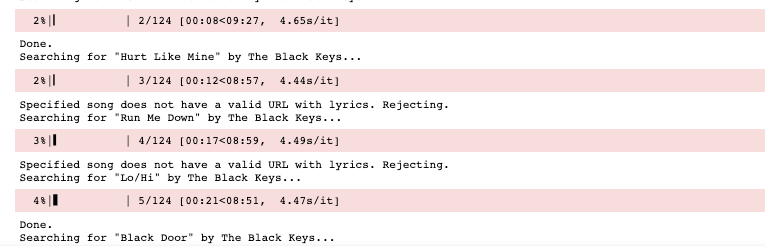

* Searched for missing songs in the retrieved data by running the missing_songs( ) function, as songs are skipped if the server is temporarily timing out.

In [18]:
missing_songs_dict = missing_songs(artists, artist_dict, lyrics_df)

* Repeated the data collection with the genius_lyrics_dataframe( ) function passing the missing_songs_dict, which returned another dataframe.

In [19]:
missing_tracks_df = genius_lyrics_dataframe(missing_songs_dict)

* Joined the two dataframes.

In [20]:
joined_df = pd.concat([lyrics_df, missing_tracks_df], axis=0).sort_values('artist_name')

* Ran the missing_songs( ) function again.

In [21]:
missing_songs_dict2 = missing_songs(artists, artist_dict, joined_df)

* Retrieved more songs using the genius_lyrics_dataframe( ) function, passing it the new dictionary of missing songs.

In [22]:
missing_tracks_df2 = genius_lyrics_dataframe(missing_songs_dict2)

* Concatinated the dataframes again.

In [23]:
joined_df = pd.concat([joined_df, missing_tracks_df2], axis=0).sort_values('artist_name')

**Saving data to .csv file**

In [24]:
joined_df.to_csv('lyrics_df.csv', index=False)

In [25]:
spotify.to_csv('Spotify_Kaggle_noduplicates.csv', index=False)